We'll first be using the "Monthly Beer Production in Austria" dataset provided [on Kaggle](https://www.kaggle.com/datasets/shenba/time-series-datasets?select=monthly-beer-production-in-austr.csv).

Let's load it up and take a look.

In [22]:
import numpy as np
import pandas as pd

df = pd.read_csv('dataset\\monthly-beer-production-in-austr.csv')
#Convert second column to NumPy array
dfn = df.iloc[:, 1:2].values

print(dfn[0:5])
df.head()

[[93.2]
 [96. ]
 [95.2]
 [77.1]
 [70.9]]


,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [23]:
df.set_index('Month', inplace=True)

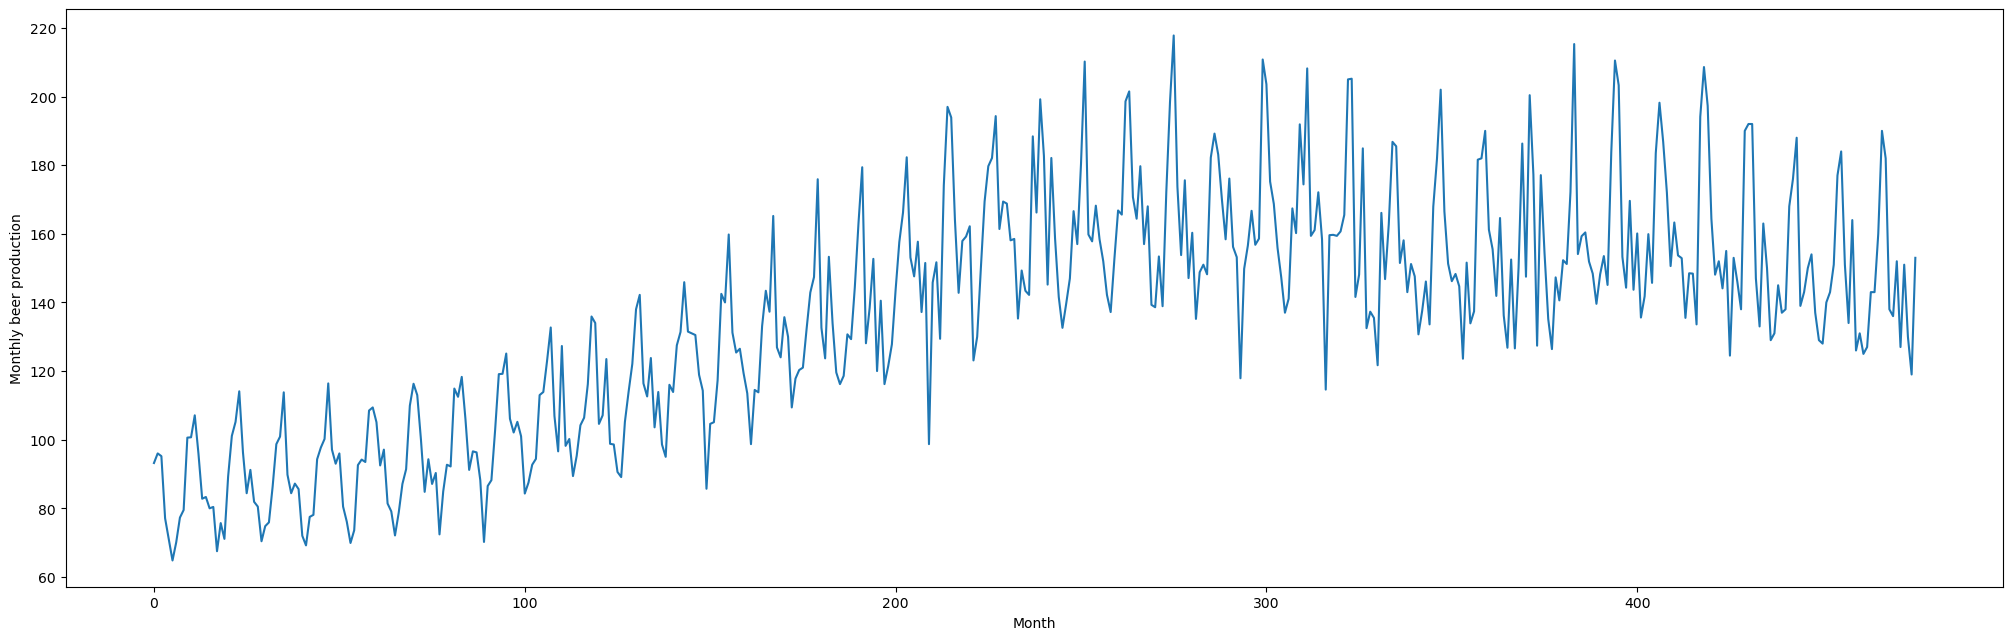

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 7.5))
plt.plot(dfn)
plt.xlabel('Month')
plt.ylabel('Monthly beer production')
plt.show()

We'll want to create a lagging table of the "Monthly Beer Production" column, so that we have the recurrent data to train the model on.

# LTSM RNN

In [25]:
#We'll be creating a deepcopy so the table doesn't change everytime we run this codeblock.
from copy import deepcopy as dc

def lag_data(df, n, column='Monthly beer production'):
    df = dc(df)

    for i in range(1, n + 1):
        df[f'{column} (t - {i})'] = df[column].shift(i)

    df.dropna(inplace=True)         #Will drop the first n rows.
    df_flip = df.iloc[:, ::-1]      #Reflect the table horizontally so that the last column is the one to be predicted against.

    return df_flip

n = 7
df_lag = lag_data(df, n)

df_lag.head()

,Monthly beer production (t - 7),Monthly beer production (t - 6),Monthly beer production (t - 5),Monthly beer production (t - 4),Monthly beer production (t - 3),Monthly beer production (t - 2),Monthly beer production (t - 1),Monthly beer production
Month,,,,,,,,
1956-08,93.2,96.0,95.2,77.1,70.9,64.8,70.1,77.3
1956-09,96.0,95.2,77.1,70.9,64.8,70.1,77.3,79.5
1956-10,95.2,77.1,70.9,64.8,70.1,77.3,79.5,100.6
1956-11,77.1,70.9,64.8,70.1,77.3,79.5,100.6,100.7
1956-12,70.9,64.8,70.1,77.3,79.5,100.6,100.7,107.1


We'll perform some normalization of the data.

In [26]:
df_lag_np = df_lag.to_numpy()

print(df_lag_np, '\n\n', df_lag_np.shape)

[[ 93.2  96.   95.2 ...  64.8  70.1  77.3]
 [ 96.   95.2  77.1 ...  70.1  77.3  79.5]
 [ 95.2  77.1  70.9 ...  77.3  79.5 100.6]
 ...
 [190.  182.  138.  ... 127.  151.  130. ]
 [182.  138.  136.  ... 151.  130.  119. ]
 [138.  136.  152.  ... 130.  119.  153. ]] 

 (469, 8)


In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()                         #Scales the data to values between 0 and 1.
df_train = scaler.fit_transform(df_lag_np)

df_train

array([[0.18562092, 0.20392157, 0.19869281, ..., 0.        , 0.01729874,
        0.06520293],
       [0.20392157, 0.19869281, 0.08039216, ..., 0.03464052, 0.06520293,
        0.07984032],
       [0.19869281, 0.08039216, 0.03986928, ..., 0.08169935, 0.07984032,
        0.22022621],
       ...,
       [0.81830065, 0.76601307, 0.47843137, ..., 0.40653595, 0.55555556,
        0.415835  ],
       [0.76601307, 0.47843137, 0.46535948, ..., 0.56339869, 0.415835  ,
        0.34264804],
       [0.47843137, 0.46535948, 0.56993464, ..., 0.42614379, 0.34264804,
        0.56886228]])

We split it into the training data and predictor.

In [28]:
X = df_train[:, 0:7]
y = df_train[:, 7]

print(X.shape, y.shape)

(469, 7) (469,)


Next, we'll select the first 80% of the data to be used for training and the rest for testing.

In [29]:
split = int(len(X) * 0.8)

split

375

In [30]:
import torch

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

#Jacking up the ranks by 1 for the model.
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

#Converting them all to PyTorch tensors.
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([375, 7, 1]),
 torch.Size([94, 7, 1]),
 torch.Size([375, 1]),
 torch.Size([94, 1]))

Creating the PyTorch dataset object.

In [31]:
from torch.utils.data import Dataset

class TSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train = TSeriesDataset(X_train, y_train)
test = TSeriesDataset(X_test, y_test)

Preparing the data for training with DataLoaders.

In [32]:
from torch.utils.data import DataLoader

batch_size = 1      #Our dataset is not particularly large
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=False)

Making the model.

In [33]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layers = layers

        self.lstm = nn.LSTM(input_size, hidden_size, layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.layers, batch_size, self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        output = self.fc(out[:, -1, :])

        return output

model = LSTM(1, 4, 1)

Training the model.

In [34]:
def train_epoch():
    model.train()
    running_loss = 0.0

    print(f'Epoch: {epoch + 1}')

    for batch_index, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()       #Zeroing gradients for each batch.
        output = model(inputs)
        loss = criterion(output, targets)
        running_loss += loss.item()
        loss.backward()             #Backward pass through the loss to calculate gradient.
        optimizer.step()            #Update parameters.

        if batch_index % 100 == 99:
            print(f'Batch: {batch_index + 1}, average loss across batches: {running_loss / 100}')

            running_loss = 0.0

def val_epoch():
    model.eval()
    running_loss = 0.0

    for inputs, targets in test_dataloader:
        with torch.no_grad():
            output = model(inputs)
            loss = criterion(output, targets)
            running_loss += loss.item()

    print(f'Validation loss: {running_loss / len(test_dataloader)}\n')

In [50]:
epochs = 50
learning_rate = 0.01
criterion = nn.MSELoss()    #Mean squared error for loss function.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    train_epoch()
    val_epoch()

Epoch: 1
Batch: 100, average loss across batches: 0.00883549064766612
Batch: 200, average loss across batches: 0.008542821508181966
Batch: 300, average loss across batches: 0.013590176688257998
Validation loss: 0.015063924217449863

Epoch: 2
Batch: 100, average loss across batches: 0.01010918868194949
Batch: 200, average loss across batches: 0.010888582646716714
Batch: 300, average loss across batches: 0.011180513133493832
Validation loss: 0.01979721641041252

Epoch: 3
Batch: 100, average loss across batches: 0.009326853328198013
Batch: 200, average loss across batches: 0.012833853335461071
Batch: 300, average loss across batches: 0.012851553895925462
Validation loss: 0.013305659536962004

Epoch: 4
Batch: 100, average loss across batches: 0.009427226033817532
Batch: 200, average loss across batches: 0.01085655875053135
Batch: 300, average loss across batches: 0.01157781410029429
Validation loss: 0.014116529127926106

Epoch: 5
Batch: 100, average loss across batches: 0.00949851494606946

Using the trained model for prediction.

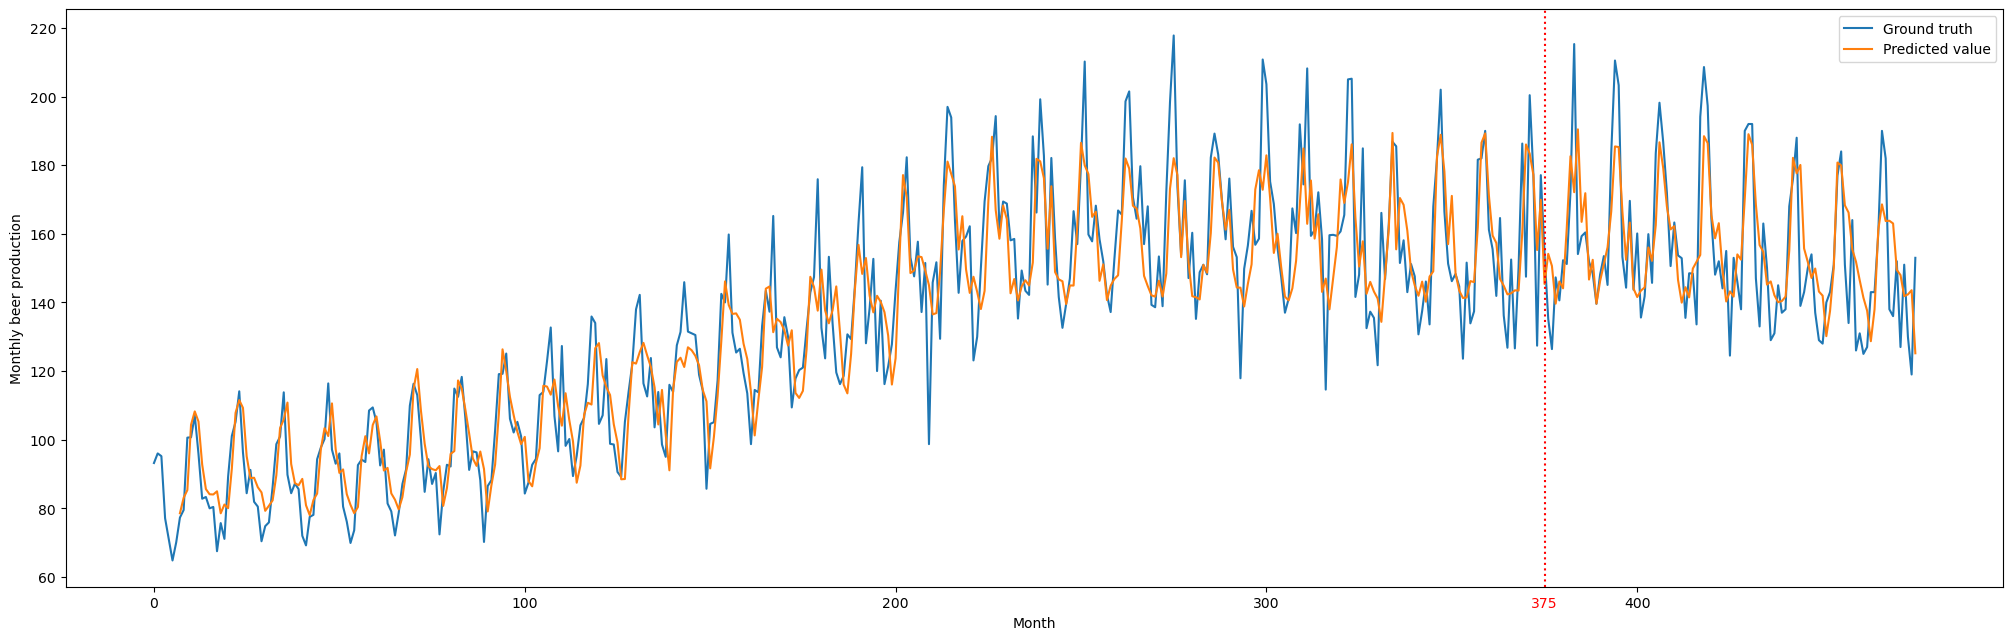

In [51]:
model.eval()

with torch.no_grad():
    predicted_vector = model(torch.cat((X_train, X_test), dim=0)).flatten()

#Playing around to get correct dimensions.
predicted = np.zeros((X.shape[0], n + 1))
predicted[:, 0] = predicted_vector
predicted = scaler.inverse_transform(predicted)[:, 0]

shifted_xvalues = np.arange(X.shape[0]) + n

plt.figure(figsize=(25, 7.5))
plt.plot(dfn, label='Ground truth')
plt.plot(shifted_xvalues, predicted, label='Predicted value')
plt.xlabel('Month')
plt.ylabel('Monthly beer production')
plt.axvline(x=split, c='r', linestyle=':')
plt.text(split, 52.4, f'{split}', verticalalignment='center', horizontalalignment='center', color='r', fontsize=10)
plt.legend()
plt.show()

# ARIMA

For ease, we'll be using the `auto_arima` function from the pmdarima library. It will automatically perform tests to determine stationarity, as well as perform a search for the optimal $p$, $d$, and $q$ values for the model.

In [44]:
df.index = pd.to_datetime(df.index)

df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [45]:
from pmdarima.arima import auto_arima

y_train_arima = df[:split]
y_test_arima = df[split:]

model_arima = auto_arima(y_train_arima, max_p=3, max_q=3, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3266.948, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3070.705, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3085.984, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3265.000, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3243.579, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3052.394, Time=0.67 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3135.329, Time=0.43 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=2886.435, Time=1.59 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2915.728, Time=0.50 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=2824.265, Time=2.51 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : 

In [46]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  375
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -1368.231
Date:                              Mon, 29 Jan 2024   AIC                           2752.462
Time:                                      06:51:54   BIC                           2783.856
Sample:                                  01-01-1956   HQIC                          2764.927
                                       - 03-01-1987                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1536      0.008   -142.814      0.000      -1.169      -1.138
ar.L2         -0.9945      0.008   -126.066      0.000      -1.010      -0.979
ma.L1          0.2018      0.032      6.321      0.000       0.139       0.264
ma.L2         -0.0280      0.032     -0.872      0.383      -0.091       0.035
ma.L3         -0.8436      0.029    -29.341      0.000      -0.900      -0.787
ar.S.L12       0.9947      0.005    204.052      0.000       0.985       1.004
ma.S.L12      -0.8248      0.039    -21.257      0.000      -0.901      -0.749
sigma2        83.1451      5.063     16.423      0.000      73.222      93.068
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                55.33
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               5.03   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now we make predictions.

In [47]:
forecast_steps = len(y_test_arima)
forecast = model_arima.predict(n_periods=forecast_steps)

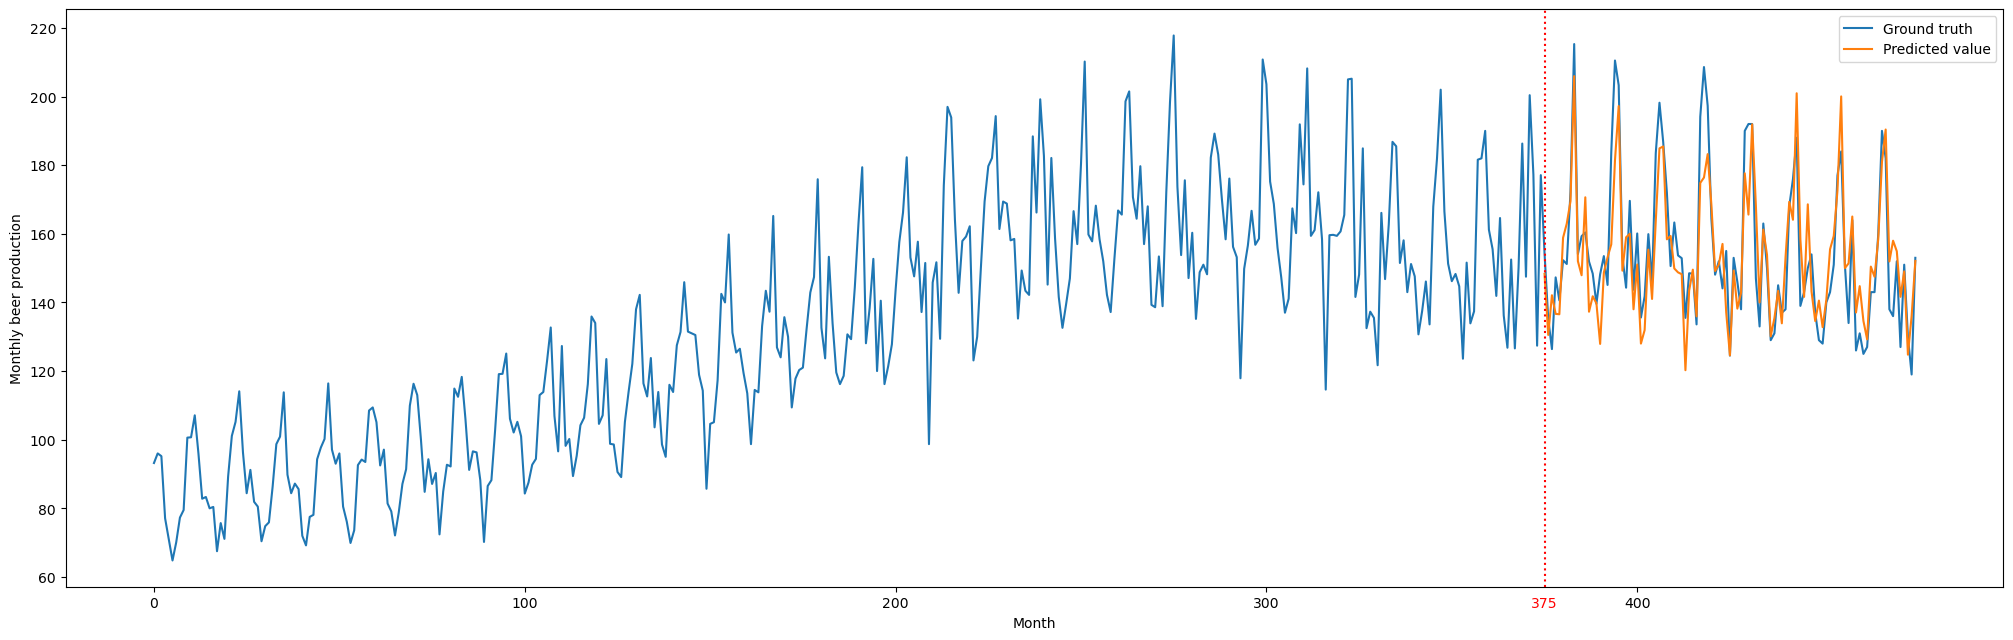

In [49]:
shifted_xvalues2 = np.arange(split, len(df))

plt.figure(figsize=(25, 7.5))
plt.plot(dfn, label='Ground truth')
plt.plot(shifted_xvalues2, np.array(forecast), label='Predicted value')
plt.xlabel('Month')
plt.ylabel('Monthly beer production')
plt.axvline(x=split, c='r', linestyle=':')
plt.text(split, 52.4, f'{split}', verticalalignment='center', horizontalalignment='center', color='r', fontsize=10)
plt.legend()
plt.show()

Let's compare the LSTM RNN and ARIMA models by looking at the root mean squared error, mean absolute error, and mean absolute percentage error metrics on the test set.

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mse_lstm = mean_squared_error(dfn[n + split:], predicted[split:], squared=False)
mae_lstm = mean_absolute_error(dfn[n + split:], predicted[split:])
mape_lstm = mean_absolute_percentage_error(dfn[n + split:], predicted[split:])

mse_arima = mean_squared_error(dfn[split:], forecast, squared=False)
mae_arima = mean_absolute_error(dfn[split:], forecast)
mape_arima = mean_absolute_percentage_error(dfn[split:], forecast)

print('LSTM Model')
print('Root mean squared error:        ', mse_lstm)
print('Mean absolute error:            ', mae_lstm)
print('Mean absolute percentage error: ', mape_lstm)
print()
print('ARIMA Model')
print('Root mean squared error:        ', mse_arima)
print('Mean absolute error:            ', mae_arima)
print('Mean absolute percentage error: ', mape_arima)

LSTM Model
Root mean squared error:         15.490404678236736
Mean absolute error:             12.304266104038726
Mean absolute percentage error:  0.08068920773787171

ARIMA Model
Root mean squared error:         11.385887266176956
Mean absolute error:             8.958546082458582
Mean absolute percentage error:  0.05765674974040649


It seems the ARIMA model performs better--at least in the context of these metrics.